In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.utils import plot_model

import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

Using TensorFlow backend.


In [2]:
# load train data
train = pd.read_csv('Data\\train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
# Find Na 
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
# Replace NA
train['title'] = train['title'].replace(np.nan, train['text'])
train.isnull().sum()

id           0
title        0
author    1957
text        39
label        0
dtype: int64

In [5]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']

In [6]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [7]:
# Dataset Preprocessing
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [8]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

In [9]:
# pad_sequences
sent_length = 20
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ... 338 206 431]
 [  0   0   0 ... 127 221 354]
 [  0   0   0 ...   1 117 332]
 ...
 [  0   0   0 ... 187 309 280]
 [  0   0   0 ... 418 471 352]
 [  0   0   0 ... 173 311  28]]


In [10]:
# model build 
embedding_vector_feature = 10
model=Sequential()
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 10)            5000      
_________________________________________________________________
lstm (LSTM)                  (None, 100)               44400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 49,501
Trainable params: 49,501
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Plot title model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [12]:
# check shape 
len(embedded_doc),y_train.shape

(20800, (20800,))

In [13]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20800, 20), (20800,))

In [14]:
# train model
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=64)

C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 12s 711us/step - loss: 0.3977 - acc: 0.8224 - val_loss: 0.2720 - val_acc: 0.8942
Epoch 2/10
16640/16640 [==============================] - 10s 577us/step - loss: 0.2445 - acc: 0.9030 - val_loss: 0.2492 - val_acc: 0.9053
Epoch 3/10
16640/16640 [==============================] - 10s 592us/step - loss: 0.2267 - acc: 0.9074 - val_loss: 0.2405 - val_acc: 0.9024
Epoch 4/10
16640/16640 [==============================] - 10s 586us/step - loss: 0.2128 - acc: 0.9125 - val_loss: 0.2379 - val_acc: 0.9000
Epoch 5/10
16640/16640 [==============================] - 10s 585us/step - loss: 0.2013 - acc: 0.9158 - val_loss: 0.2337 - val_acc: 0.9055
Epoch 6/10
16640/16640 [==============================] - 10s 583us/step - loss: 0.1933 - acc: 0.9191 - val_loss: 0.2305 - val_acc: 0.9038
Epoch 7/10
16640/16640 [==============================] - 10s 578us/step - loss: 0.1865 - acc: 0.9238 - val_loss: 0.2

In [15]:
# load test
test = pd.read_csv('Data\\test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [16]:
# check na in test
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [17]:
# Replace na
test['title'] = test['title'].replace(np.nan, test['text'])
test.isnull().sum()

id          0
title       0
author    503
text        7
dtype: int64

In [18]:
# prepare test data for NN
X_test=test
messages=X_test.copy()
messages.reset_index(inplace=True)
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
onehot_rep = [one_hot(words, vo_size) for words in corpus]
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
X_test_final=np.array(embedded_doc)

In [19]:
# predict final
y_pred_final=model.predict_classes(X_test_final)
y_pred_final = pd.DataFrame(y_pred_final)
submit = pd.concat([test['id'].reset_index(drop=True), y_pred_final], axis=1)
submit.rename(columns={ submit.columns[1]: "label" }, inplace = True)
submit.isnull().sum()
submit.to_csv('submit1.csv', index=False)

In [20]:
# Save model
model.save_weights("model_title.h5")

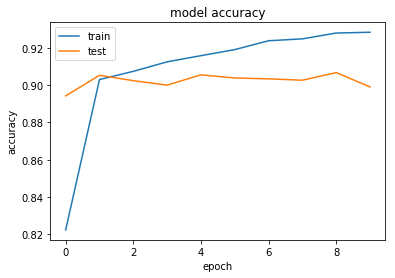

In [24]:
# summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

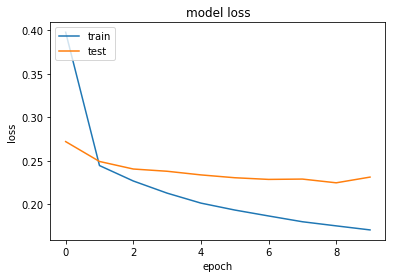

In [25]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()